<a href="https://colab.research.google.com/github/mudogruer/transformers/blob/main/classification_of_emotions_roberta_base_with_dairai_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Dataset Loading

In [1]:
!pip install -q datasets
!pip install -q transformers[torch]

In [2]:
from datasets import load_dataset

In [3]:
emotions = load_dataset("dair-ai/emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_ds.column_names

['text', 'label']

In [8]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [9]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [10]:
train_ds["text"][:5]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong',
 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
 'i am feeling grouchy']

In [11]:
import pandas as pd

In [12]:
emotions.set_format(type="pandas")

In [13]:
df = emotions["train"][:]

In [14]:
df.head(5)

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

In [16]:
df["label_name"] = df["label"].apply(label_int2str)

In [17]:
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [18]:
import matplotlib.pyplot as plt

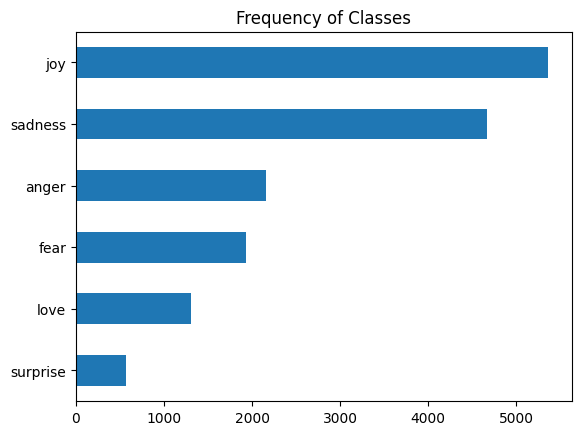

In [19]:
df["label_name"].value_counts(ascending = True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

#dataset is unbalanced
We can use 'oversample' or 'undersample' techniques here
<br>Oversample: increase small data rondomly until it is equal largest one.
<br>Undersample: this is oposite of oversample

lib: imbalanced learn

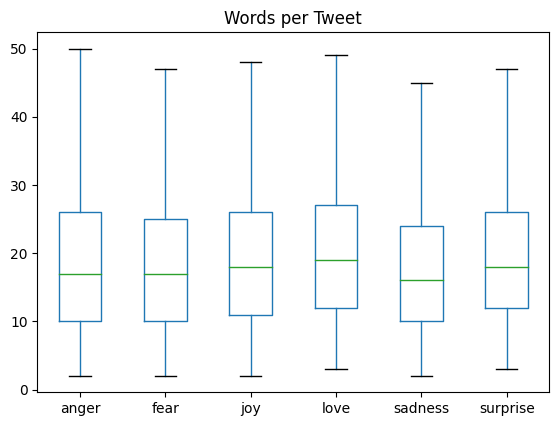

In [20]:
df["Words per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words per Tweet", by ="label_name", grid =False,
           showfliers = False)
plt.suptitle("")
plt.xlabel("")
plt.show()


In [21]:
emotions.reset_format()

##Data Preprocessing

1) letter-based tokenization

In [22]:
text = "Who let the dogs out?"
text

'Who let the dogs out?'

In [23]:
tokenized_text = list(text)
print(tokenized_text)

['W', 'h', 'o', ' ', 'l', 'e', 't', ' ', 't', 'h', 'e', ' ', 'd', 'o', 'g', 's', ' ', 'o', 'u', 't', '?']


In [24]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '?': 1, 'W': 2, 'd': 3, 'e': 4, 'g': 5, 'h': 6, 'l': 7, 'o': 8, 's': 9, 't': 10, 'u': 11}


In [25]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[2, 6, 8, 0, 7, 4, 10, 0, 10, 6, 4, 0, 3, 8, 5, 9, 0, 8, 11, 10, 1]


One-hot encoding

In [26]:
import torch

In [27]:
input_ids = torch.tensor(input_ids)

In [28]:
import torch.nn.functional as F

In [29]:
one_hot_encoding = F.one_hot(input_ids, num_classes = len(token2idx))

In [30]:
one_hot_encoding.shape

torch.Size([21, 12])

In [31]:
print(f"Token:{tokenized_text[0]}, Tensor Index: {input_ids[0]}")

Token:W, Tensor Index: 2


In [32]:
print(f"On-hot: {one_hot_encoding[0]}")

On-hot: tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])


Word-based tokenization

In [33]:
tokenized_text = text.split()
print(tokenized_text)

['Who', 'let', 'the', 'dogs', 'out?']


Sub-word-based tokenization wth transformers lib

In [34]:
from transformers import AutoTokenizer


In [130]:
model_ckpt = "roberta-base"

In [131]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [132]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [0, 12375, 905, 5, 3678, 66, 116, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [133]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['<s>', 'Who', 'Ġlet', 'Ġthe', 'Ġdogs', 'Ġout', '?', '</s>']


In [134]:
tokenizer.convert_tokens_to_string(tokens)

'<s>Who let the dogs out?</s>'

In [135]:
tokenizer.vocab_size

50265

In [136]:
tokenizer.model_max_length

512

In [137]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation= True)

In [138]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[0, 118, 46405, 619, 32386, 2], [0, 118, 64, 213, 31, 2157, 98, 24418, 7, 98, 37689, 7917, 95, 31, 145, 198, 951, 54, 14534, 8, 16, 24628, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [139]:
emotions_encoded = emotions.map(tokenize, batched = True,
                                batch_size = 32)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [140]:
#we need to make padding for shorter len text than max_len.
#It gives 0 val. to shorter text's tokens

from transformers import DataCollatorWithPadding

In [141]:
data_collator = DataCollatorWithPadding(tokenizer = tokenizer)

In [142]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

#Training Process

In [143]:
from transformers import AutoModelForSequenceClassification

In [144]:
#amount of labels in dataset
num_labels = 6

In [145]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [146]:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           num_labels = num_labels).to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
!pip install -q evaluate

In [148]:
#we need to use metrics and this lib will help
import evaluate

In [149]:
accuracy = evaluate.load("accuracy")

In [150]:
import numpy as np

In [151]:
def compute_metrics(eval_pred):
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis = 1)
  return accuracy.compute(predictions=predictions,
                          references = labels)

In [152]:
from huggingface_hub import notebook_login

In [153]:
notebook_login()

In [154]:
from transformers import TrainingArguments

In [156]:
training_args = TrainingArguments(
    output_dir = "roberta-emotion",
    num_train_epochs = 3,
    per_device_eval_batch_size=32,
    per_device_train_batch_size=32,
    weight_decay=0.01,
    evaluation_strategy= "epoch",
    save_strategy="epoch",
    load_best_model_at_end= True,
    push_to_hub = True,
    report_to = "none"

)

In [157]:
from transformers import Trainer

In [158]:
trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = tokenizer
)

In [159]:
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.610300,0.251581,0.919500
2,0.198100,0.174719,0.934500
3,0.121400,0.139396,0.938000


TrainOutput(global_step=1500, training_loss=0.3099309514363607, metrics={'train_runtime': 134.0344, 'train_samples_per_second': 358.117, 'train_steps_per_second': 11.191, 'total_flos': 1275328641889152.0, 'train_loss': 0.3099309514363607, 'epoch': 3.0})

In [161]:
preds_output = trainer.predict(emotions_encoded["test"])
preds_output

PredictionOutput(predictions=array([[ 7.037662  , -1.0661702 , -1.5556115 , -0.02437955, -1.8506087 ,
        -2.3300867 ],
       [ 7.030322  , -1.0965502 , -1.5246956 , -0.14652756, -1.8574625 ,
        -2.2349365 ],
       [ 7.0313063 , -1.0510186 , -1.5676394 , -0.0814482 , -1.8146255 ,
        -2.371812  ],
       ...,
       [-1.3938028 ,  6.9983354 , -0.48652554, -1.7640231 , -2.2232847 ,
        -1.3909332 ],
       [-1.6620551 ,  7.013596  , -0.45199096, -1.9517512 , -2.046195  ,
        -1.183399  ],
       [-1.4826754 , -1.2256844 , -2.399138  , -1.5366813 ,  3.918974  ,
         3.4844112 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 4]), metrics={'test_loss': 0.1477133184671402, 'test_accuracy': 0.932, 'test_runtime': 1.5977, 'test_samples_per_second': 1251.776, 'test_steps_per_second': 39.431})

In [164]:
preds_output.metrics

{'test_loss': 0.1477133184671402,
 'test_accuracy': 0.932,
 'test_runtime': 1.5977,
 'test_samples_per_second': 1251.776,
 'test_steps_per_second': 39.431}

In [165]:
y_preds = np.argmax(preds_output.predictions, axis = 1)

In [166]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [171]:
def plot_confusion_matix(y_pred, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize ='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot(cmap = "Blues", values_format = ".2f", ax = ax,
            colorbar = False)
  plt.title("Normalized confusion matrix(Roberta)")
  plt.show()

In [168]:
y_valid = np.array(emotions_encoded["test"]["label"])

In [169]:
labels = emotions["train"].features["label"].names

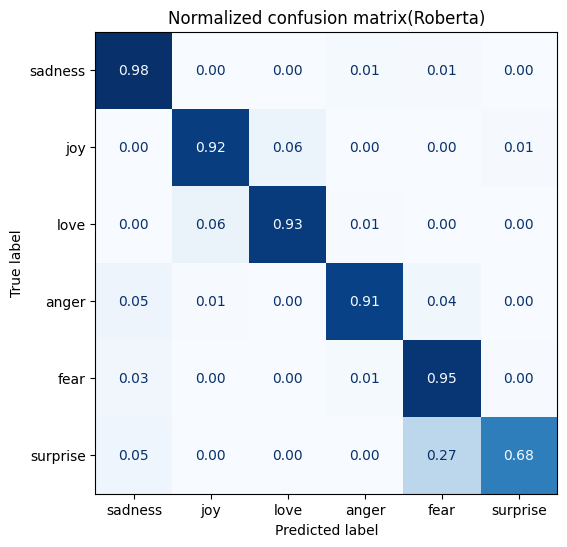

In [172]:
plot_confusion_matix(y_preds, y_valid, labels)

In [173]:
trainer.push_to_hub(commit_message = "Training completed")

CommitInfo(commit_url='https://huggingface.co/mudogruer/roberta-emotion/commit/ce6dc9e6c995fbca922b96e82dc50bbbab060f66', commit_message='Training completed', commit_description='', oid='ce6dc9e6c995fbca922b96e82dc50bbbab060f66', pr_url=None, pr_revision=None, pr_num=None)

In [174]:
from transformers import pipeline

In [175]:
model_id = "mudogruer/distilbert-emotion"

In [176]:
classifier = pipeline("text-classification",model=model_id)

In [177]:
custom_text = "I have never felt this feeling before!"

In [178]:
preds = classifier(custom_text, return_all_scores = True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [179]:
preds_df = pd.DataFrame(preds[0])

In [180]:
preds_df["label"] = emotions["train"].features["label"].names

In [181]:
preds_df

,label,score
0,sadness,0.021262
1,joy,0.819527
2,love,0.009309
3,anger,0.093284
4,fear,0.029722
5,surprise,0.026896


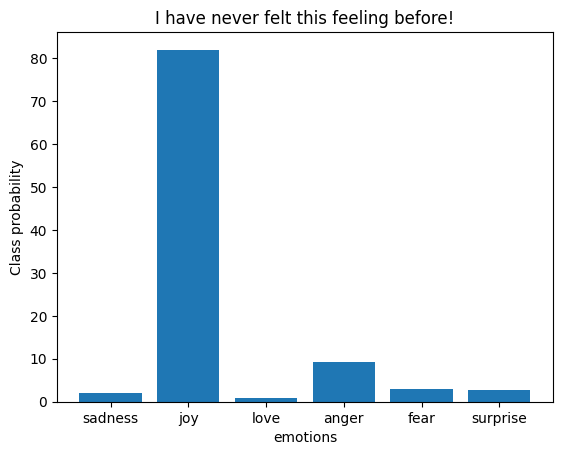

In [182]:
plt.bar(labels, 100*preds_df["score"])
plt.title(f"{custom_text}")
plt.xlabel("emotions")
plt.ylabel("Class probability")
plt.show()